In [1]:
import cv2
import numpy as np
import matplotlib . pyplot as plt

img_width = 640
img_height = 480
image_size = ( img_width , img_height )
calibration_flags = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC + cv2.fisheye.CALIB_FIX_SKEW

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
calibration_flags = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC + cv2.fisheye.CALIB_FIX_SKEW
# inner size of chessboard

width = 9
height = 6
square_size = 0.025 # 0.025 meters

# prepare object points , like (0 ,0 ,0) , (1 ,0 ,0) , (2 ,0 ,0) .... ,(8 ,6 ,0)
objp = np.zeros((height * width, 1, 3), np.float64)
objp[: , 0, :2] = np.mgrid[0:width, 0:height].T.reshape(-1, 2)
objp = objp * square_size # Create real world coords . Use your metric .

# Arrays to store object points and image points from all the images .
objpoints = [] # 3d point in real world space
imgpointsR = [] # 2d points in image plane .
imgpointsL = [] # 2d points in image plane .
img_width = 640
img_height = 480
image_size = ( img_width , img_height )

path = ""
image_dir = path + "pairs/"
# image_dir = path + "fixed/"

number_of_images = 8

for i in range (1, number_of_images):
    # read image

    if i == 30:
        continue

    imgL = cv2.imread(image_dir + "left_%02d.png" % i)
    grayL = cv2.cvtColor (imgL, cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    retL, cornersL = cv2.findChessboardCorners(grayL, (width, height), cv2.
        CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.
        CALIB_CB_NORMALIZE_IMAGE )
    
    imgR = cv2.imread(image_dir + "right_%02d.png" % i)
    grayR = cv2.cvtColor (imgL, cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    retR, cornersR = cv2.findChessboardCorners(grayR, (width, height), cv2.
        CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.
        CALIB_CB_NORMALIZE_IMAGE )
    
    Y, X, channels = imgL.shape
    # skip images where the corners of the chessboard are too close to the edges of the image
    if (retL == True and retR == True):
        minRx = cornersL[:, :, 0].min()
        maxRx = cornersL[:, :, 0].max()
        minRy = cornersL[:, :, 1].min()
        maxRy = cornersL[:, :, 1].max()

        border_threshold_x = X /12
        border_threshold_y = Y /12

        x_thresh_bad = False
        if ( minRx < border_threshold_x ):
            x_thresh_bad = True

        y_thresh_bad = False
        if ( minRy < border_threshold_y ):
            y_thresh_bad = True

        if ( y_thresh_bad == True ) or ( x_thresh_bad == True ):
            continue

    # If found , add object points , image points ( after refining them )
    if retL == True and retR == True:
        objpoints.append(objp)

        # improving the location of points (sub - pixel )
        cornersL = cv2.cornerSubPix(grayL, cornersL, (11, 11), (-1, -1), criteria)
        cornersR = cv2.cornerSubPix(grayR, cornersR, (11, 11), (-1, -1), criteria)

        imgpointsL.append(cornersL)
        imgpointsR.append(cornersR)

        # Draw and display the corners
        # Show the image to see if pattern is found ! imshow function .
        # cv2.drawChessboardCorners(img, (width, height), corners2, ret)
        # cv2.imshow("Corners", img )
        # cv2.waitKey(5)
    else :
        print ("Chessboard couldn't be detected. Image pair: ", i)
        continue

    

In [2]:
N_OK = len(objp)
K_left = np.zeros((3, 3))
D_left = np.zeros((4, 1))
rvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range (N_OK)]
tvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range (N_OK)]
ret, K, D, _, _= \
        cv2.fisheye.calibrate(
        objpoints,
        imgpointsL,
        image_size,
        K_left,
        D_left,
        rvecs,
        tvecs,
        calibration_flags,
        (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6)
    )

K_right = np.zeros((3, 3))
D_right = np.zeros((4, 1))
rvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range (N_OK)]
tvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range (N_OK)]
ret, K_right, D_right, _, _= \
        cv2.fisheye.calibrate(
        objpoints,
        imgpointsR,
        image_size,
        K_right,
        D_right,
        rvecs,
        tvecs,
        calibration_flags,
        (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6)
    )

In [3]:

imgpointsLeft = np.asarray(imgpointsL, dtype=np.float64)
imgpointsRight = np.asarray(imgpointsR, dtype=np.float64)
(RMS, _, _, _, _, rotationMatrix, translationVector) = cv2.fisheye.stereoCalibrate(
        objpoints, imgpointsLeft, imgpointsRight,
        K_left, D_left,
        K_right, D_right,
        image_size, None, None,
        cv2.CALIB_FIX_INTRINSIC,
        (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.01))
R2 = np.zeros([3, 3])
P1 = np.zeros([3, 4])
P2 = np.zeros([3, 4])
Q = np.zeros([4, 4])
# Rectify calibration results
(leftRectification, rightRectification, leftProjection, rightProjection,
    dispartityToDepthMap ) = cv2.fisheye.stereoRectify(
    K_left, D_left,
    K_right, D_right,
    image_size,
    rotationMatrix, translationVector,
    0, R2, P1, P2, Q,
    cv2.CALIB_ZERO_DISPARITY, (0, 0), 0, 0)

map1_left, map2_left = cv2.fisheye.initUndistortRectifyMap(
    K_left, D_left, leftRectification,
    leftProjection, image_size, cv2.CV_16SC2 )

map1_right, map2_right = cv2.fisheye.initUndistortRectifyMap (
    K_right, D_right, rightRectification,
    rightProjection, image_size, cv2.CV_16SC2 )

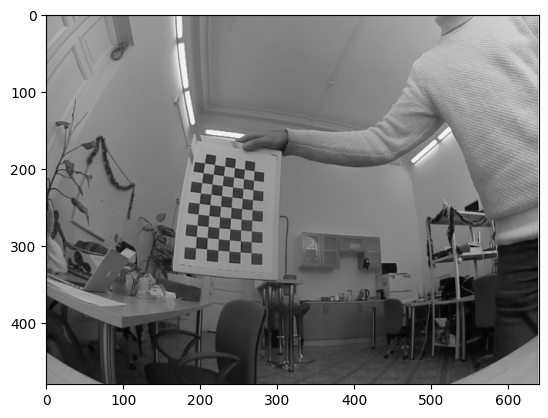

In [7]:
img_l = cv2.imread('pairs/left_28.png')
img_r = cv2.imread('pairs/right_28.png')

dst_L = cv2.remap(img_l, map1_left, map2_left, cv2.INTER_LINEAR)
dst_R = cv2.remap(img_r, map1_right, map2_right, cv2.INTER_LINEAR)

N, XX, YY = dst_L.shape[:: -1] # RGB image size
visRectify = np.zeros((YY, XX*2, N), np.uint8) # create a new image with a new size (height, 2*width)
visRectify [:, 0:XX:, :] = dst_L # left image assignment
visRectify [:, XX:XX*2:, :] = dst_R # right image assignment
# draw horizontal lines
for y in range (0, YY, 10):
    cv2.line(visRectify, (0, y), (XX*2, y), (255, 0, 0))
# cv2.imshow('visRectify', visRectify ) # display image with lines
# plt.imshow(visRectify)
plt.imshow(img_l)

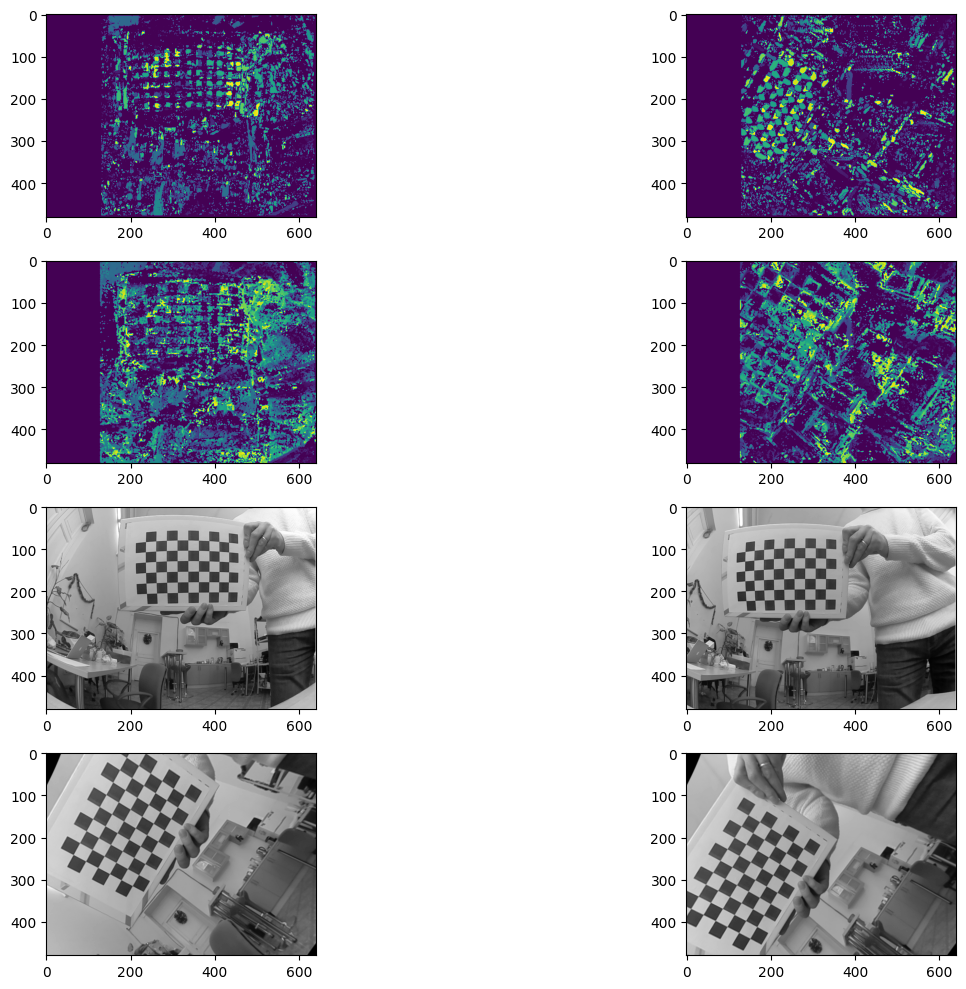

In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img_l = cv2.imread('pairs/left_03.png')
img_r = cv2.imread('pairs/right_03.png')

dst_L = cv2.remap(img_l, map1_left, map2_left, cv2.INTER_LINEAR)
dst_R = cv2.remap(img_r, map1_right, map2_right, cv2.INTER_LINEAR)

# Create StereoSGBM object
window_size = 3  # Window size for matching, must be odd
min_disparity = 0  # Minimum disparity
num_disparities = 128  # Number of disparities
sgbm = cv2.StereoSGBM_create(
    minDisparity=min_disparity,
    numDisparities=num_disparities,
    blockSize=window_size
)
# Compute disparity map
sgbm_pre = sgbm.compute(img_l, img_r)
sgmb_pre = cv2.normalize(sgbm_pre, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

sgbm_post = sgbm.compute(dst_L, dst_R)
sgmb_post = cv2.normalize(sgbm_post, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

img_l = cv2.cvtColor(img_l, cv2.COLOR_BGR2GRAY)
img_r = cv2.cvtColor(img_r, cv2.COLOR_BGR2GRAY)
dst_L = cv2.cvtColor(dst_L, cv2.COLOR_BGR2GRAY)
dst_R = cv2.cvtColor(dst_R, cv2.COLOR_BGR2GRAY)

bm = cv2.StereoBM_create(numDisparities=num_disparities, blockSize=9)
bm_pre = bm.compute(img_l, img_r)
bm_pre = cv2.normalize(bm_pre, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

bm_post = bm.compute(dst_L, dst_R)
bm_post = cv2.normalize(bm_post, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

p, ax = plt.subplots(4, 2, figsize=(16, 10))
ax[0, 0].imshow(bm_pre) 
ax[1, 0].imshow(sgbm_pre) 
ax[2, 0].imshow(img_l, 'gray') 
ax[3, 0].imshow(dst_L, 'gray') 

ax[0, 1].imshow(bm_post) 
ax[1, 1].imshow(sgbm_post) 
ax[2, 1].imshow(img_r, 'gray') 
ax[3, 1].imshow(dst_R, 'gray') 

plt.tight_layout()
plt.show()


# Display the disparity map
# cv2.imshow('Disparity Map', disparity_map_normalized)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [39]:
import numpy as np

def census_transform(image, window_size=3):
    # Padding to handle borders
    padded_img = np.pad(image, (window_size//2, window_size//2), mode='constant')
    # Create an empty array for the census transform
    census = np.zeros_like(image, dtype=np.uint8)
    for i in range(window_size):
        for j in range(window_size):
            if i == window_size // 2 and j == window_size // 2:
                continue  # Skip the center pixel
            census <<= 1
            census += (padded_img[i:i+len(image), j:j+len(image[1])] >= image)
    return census

def hamming_distance(census1, census2):
    return np.count_nonzero(census1 != census2, axis=-1)

def block_matching(left_img, right_img, window_size=5, max_disparity=64):
    left_census = census_transform(left_img, window_size)
    right_census = census_transform(right_img, window_size)
    h, w = left_img.shape
    disparities = np.zeros_like(left_img, dtype=np.float32)
    half_window = window_size // 2
    for y in range(h):
        for x in range(w):
            best_match = None
            min_cost = float('inf')
            for d in range(max_disparity):
                # if x - d - half_window < 0 or x - d + half_window > right_census.shape[1]:
                if x - d < 0 or x - d + window_size -1 > right_census.shape[1]:
                    continue  # Skip out-of-bounds pixels
                census_left = left_census[y:y+window_size, x:x+window_size]
                census_right = right_census[y:y+window_size, x-d:x-d+window_size]

                if census_left.shape != census_right.shape:
                    continue
                cost = hamming_distance(census_left, census_right).sum()
                if cost < min_cost:
                    min_cost = cost
                    best_match = d
            disparities[y, x] = best_match
    return disparities

# Example usage
img_l = cv2.imread('pairs/left_01.png')
img_r = cv2.imread('pairs/right_03.png')

left_img = cv2.cvtColor(img_l, cv2.COLOR_BGR2GRAY)
right_img = cv2.cvtColor(img_r, cv2.COLOR_BGR2GRAY)
disparity_map = block_matching(left_img, right_img)
plt.imshow(disparity_map)


KeyboardInterrupt: 